## Metric figures

This notebook contains the code to generate figures associated with the weekly metrics. 

Start by importing necessary libraries and turning off warnings

In [1]:
import os, sys, importlib, json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import nbinom as nbinom
sys.path.append( os.path.abspath(os.path.join('..')) )
import utils.forecast as forecast
import utils.utils as gen_utils

import warnings
warnings.filterwarnings('ignore')

# Opening config file
f = open('../fpaths_config.json')
paths = json.load(f)

metric_fil = paths["mean_metric_fil"]
amt_metrics_path = paths['amt_metrics']
metric_figures_path = paths['metric_figures_path']


## RMSE for 4 week intervals compared to total RMSE

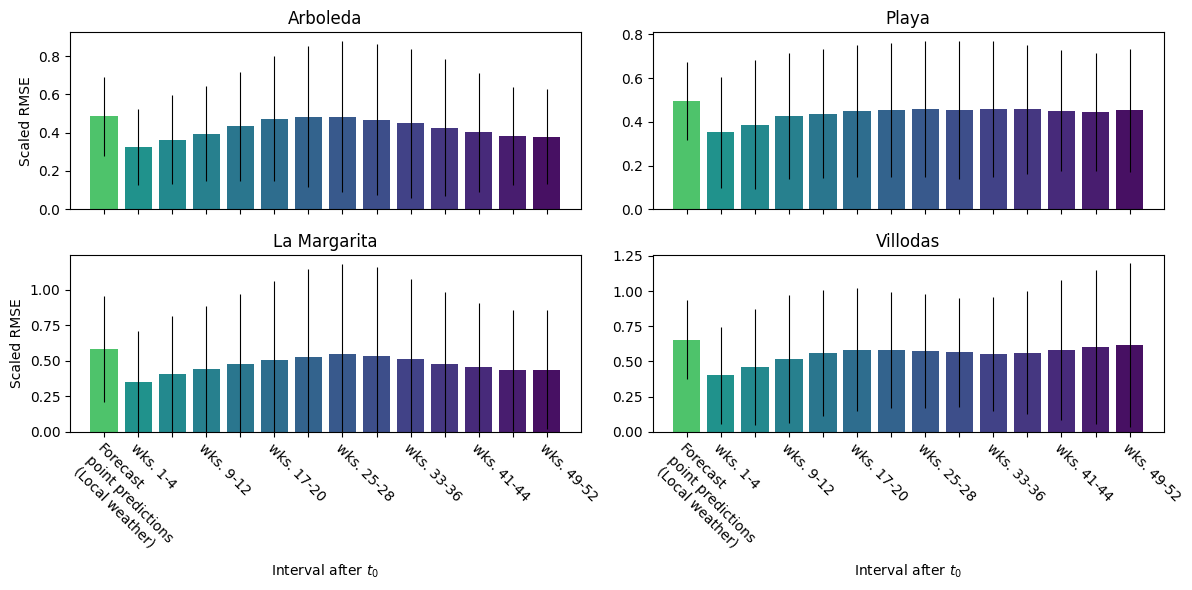

In [2]:
importlib.reload(forecast)

#Avg. mosquitoes
avg_mosquitos = [8.718, 12.786, 1.488, 1.624]

metrics = gen_utils.load_csv(metric_fil)

metrics = metrics[~metrics.Site.str.contains('baseline')]
metrics = metrics[(metrics.Scaler_win==13) & (metrics.Forecast_win==52) & (metrics.Trap_smoothing_flag==True)]

sites = ['Arboleda', 'Playa', 'La_Margarita', 'Villodas']

fig, axs = plt.subplots(2,2, sharex=True, figsize=(12,6))
axs = axs.ravel()

cmap = plt.get_cmap('viridis')
colors = [cmap(0.72)]
    
fig_idx=0
labels = ['Forecast\npoint predictions\n(Local weather)']
percentage_start = 0.55

amt = 4
wks_vals = np.arange(1,54,amt)
num_wks = len(wks_vals)
for i,j in zip(wks_vals,np.arange(1,num_wks)):
    labels.append('wks. {}-{}'.format(i,i+amt-1))
    colors.append(cmap(percentage_start-j*percentage_start/num_wks))

for site,ax,avg_mos in zip(sites,axs,avg_mosquitos):
    site_metrics = metrics[metrics.Site.str.contains(site)]
    local = site_metrics[site_metrics.Weather.str.contains('site')]
        
    months_fil = '{}/{}_site_smoothed_{}amt_metrics.csv'.format(amt_metrics_path,site, amt)
    site_months = gen_utils.load_csv(months_fil)
    
    rmse_months = site_months.filter(regex='RMSE')
    rmse_months = rmse_months.filter(regex='amt')
    
    month_mus = rmse_months.mean().values
    month_sigs = rmse_months.std().values
    
    mus = [local.RMSE_mu.values[0]] + list(month_mus)
    sigs = [local.RMSE_sig.values[0]] + list(month_sigs)

    mus = np.asarray(mus)/avg_mos
    sigs = np.asarray(sigs)/avg_mos

    ax.bar(labels, mus, color=colors)
    ax.errorbar(labels, mus, ls='none', yerr = sigs, ecolor='k', elinewidth=0.8)
    ax.set_xlim([-1,len(labels)])
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xticklabels(labels, rotation=-45, ha="left", rotation_mode = "anchor")
    ax.set_title(site.replace('_', ' '))
    if ( (fig_idx % 2) == 0):
        ax.set_ylabel('Scaled RMSE')
    
    for i,label in zip(np.arange(len(ax.xaxis.get_ticklabels())), ax.xaxis.get_ticklabels()):
        if ((i>0) & ( ((i % 2) == 0 ))):
            label.set_visible(False)
    if fig_idx>1:
        ax.set_xlabel(r'Interval after $t_0$')
    
    fig_idx+=1
fig.tight_layout()

fig.savefig('{}/local_mols_{}_amt_baseline_forecast_comparions.png'.format(metric_figures_path, amt), dpi=300, bbox_inches='tight')
